# This code using Hybrid Planning RRT*-MMC for UR10e in Bin Picker applications

In [1]:
# !pip3 install pybullet
# !pip3 install roboticstoolbox-python[collision]
# !pip install roboticstoolbox-python==1.1.0
# !pip3 install ipympl

## Include the library 

In [2]:
# Include library Robotics toolbox
import swift
import math as m
import spatialgeometry as sg
from spatialmath.base import *
import roboticstoolbox as rtb
import spatialmath as sm
import numpy as np
import qpsolvers as qp
import cProfile
from spatialmath.pose3d import SE3
# Include library RRT
from random import random
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from collections import deque
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from timeit import default_timer as timer

# Geometry Class

In [3]:
class Line():
    def __init__(self, p0, p1):
            self.p0 = np.array(p0)
            self.p1 = np.array(p1)
            self.dirn = np.array(p1) - np.array(p0)
            self.dist = np.linalg.norm(self.dirn)
            self.dirn /= self.dist # normalize
    def path(self, t):
            return self.p0 + t * self.dirn
    
class Sphere(object):
    #Cube define by it center
    def __init__(self, x=0, y=0, z=0, radius =1):
        self.x = x
        self.y = y
        self.z = z
        self.center = [x, y, z]
        self.radius = radius
    def isPointinside(self, p):
        dist = p.distance(self.center)
        if(dist <= self.radius):
            return True
        return False 

def distance(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

#https://scikit-spatial.readthedocs.io/en/stable/gallery/intersection/plot_sphere_line.html
# http://paulbourke.net/geometry/circlesphere/index.html#linesphere

def isInObstacle(point, spheres, radius):
    for obs in spheres:
        dist = distance(point, obs.center)
        if dist < radius:
            return True
    return False

def Intersection(line, sphere, radius):
    """
    http://paulbourke.net/geometry/circlesphere/index.html#linesphere
    """
    a = np.dot(line.dirn, line.dirn)
    b = 2 * np.dot(line.dirn, line.p0  - sphere.center)
    c = np.dot(line.p0  - sphere.center, line.p0  - sphere.center) - radius**2
    discriminant = b * b - 4 * a * c
    if discriminant < 0:
        return False # the line does not intersect the sphere.
    return True       # the line intersect the sphere.

def isThruObstacle(line, obstacles, radius):
    for obs in obstacles:
        if Intersection(line, obs, radius):
            return True # the line intersect the sphere.
    return False # the line does not intersect the sphere.

class Graph:
    """
    Class initialize Graph
    """
    def __init__(self, startpos, endpos):
        self.startpos = startpos
        self.endpos = endpos

        self.vertices = [startpos]
        self.edges = []
        self.success = False

        self.vex2idx = {startpos:0}
        self.neighbors = {0:[]}
        self.distances = {0:0.}

        self.sx = endpos[0] - startpos[0]
        self.sy = endpos[1] - startpos[1]
        self.sz = endpos[2] - startpos[2]

    def add_vertex(self, pos):
        try:
            idx = self.vex2idx[pos]
        except:
            idx = len(self.vertices)
            self.vertices.append(pos)
            self.vex2idx[pos] = idx
            self.neighbors[idx] = []
        return idx

    def add_edge(self, idx1, idx2, cost):
        self.edges.append((idx1, idx2))
        self.neighbors[idx1].append((idx2, cost))
        self.neighbors[idx2].append((idx1, cost))


    def randomPos(self):
        rx = random()
        ry = random()
        rz = random()
        posx = self.startpos[0] - (self.sx / 2.) + rx * self.sx * 2
        posy = self.startpos[1] - (self.sy / 2.) + ry * self.sy * 2
        posz = self.startpos[2] - (self.sz / 2.) + rz * self.sz * 2
        return posx, posy, posz
    

# Visualization

In [4]:
def plot(G, Obstacles, path = None):
    px = [x for x, y, z in G.vertices]
    py = [y for y, y, z in G.vertices]
    pz = [z for x, y, z in G.vertices]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.scatter(px, py, pz,  c='black', alpha=0.1) # add alpha=0 --> node transparent
    ax.scatter(G.startpos[0], G.startpos[1],G.startpos[2], c='red') #start point
    ax.scatter(G.endpos[0], G.endpos[1], G.endpos[2], c='blue') #end point
   
    #Line RRT
    lines = [(G.vertices[edge[0]], G.vertices[edge[1]]) for edge in G.edges]
    lc = Line3DCollection(lines, colors='green', linewidth=0.7, linestyle="--")
    ax.add_collection(lc)

     # Obstacles plot
    for obs in Obstacles:
        (xs,ys,zs) = drawSphere(obs.x,obs.y,obs.z,obs.radius)
        ax.plot_wireframe(xs, ys, zs, color="b")

    # Shortest path
    if path is not None:
        paths = [(path[i], path[i+1]) for i in range(len(path)-1)]
        lc2 = Line3DCollection(paths, colors='red', linewidths=3)
        ax.add_collection(lc2)

#     ax.autoscale()
    plt.rcParams['figure.figsize'] = [30, 30]
    ax.margins(0.1)
    plt.show()

# RRT algortithms

In [5]:
def nearest(G, vex, obstacles, radius):
    Nvex = None
    Nidx = None
    minDist = float("inf")

    for idx, v in enumerate(G.vertices):
        line = Line(v, vex)
        if isThruObstacle(line, obstacles, radius):
            continue
        
        dist = distance(v, vex)
        if dist < minDist:
            minDist = dist
            Nidx = idx
            Nvex = v
    return Nvex, Nidx


def steerVertex(randvex, nearvex, stepSize):
    dirn = np.array(randvex) - np.array(nearvex)
    length = np.linalg.norm(dirn)
    dirn = (dirn / length) * min (stepSize, length)
    newvex = (nearvex[0]+dirn[0], nearvex[1]+dirn[1], nearvex[2]+dirn[2])
    return newvex


##--- Visualize function
def drawSphere(xCenter, yCenter, zCenter, r):
    #draw sphere
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x=np.cos(u)*np.sin(v)
    y=np.sin(u)*np.sin(v)
    z=np.cos(v)
    # shift and scale sphere
    x = r*x + xCenter
    y = r*y + yCenter
    z = r*z + zCenter
    return (x,y,z)



# This function for animation

def dijkstra(G):
    srcIdx = G.vex2idx[G.startpos]
    dstIdx = G.vex2idx[G.endpos]

    # build dijkstra
    nodes = list(G.neighbors.keys())
    dist = {node: float('inf') for node in nodes}
    prev = {node: None for node in nodes}
    dist[srcIdx] = 0

    while nodes:
        curNode = min(nodes, key=lambda node: dist[node])
        nodes.remove(curNode)
        if dist[curNode] == float('inf'):
            break

        for neighbor, cost in G.neighbors[curNode]:
            newCost = dist[curNode] + cost
            if newCost < dist[neighbor]:
                dist[neighbor] = newCost
                prev[neighbor] = curNode

    # retrieve path
    path = deque()
    curNode = dstIdx
    while prev[curNode] is not None:
        path.appendleft(G.vertices[curNode])
        curNode = prev[curNode]
    path.appendleft(G.vertices[curNode])
    return list(path)


def RRT(startpos, endpos, n_iter, radius, goal_radius, stepSize, obstacles):
    start = timer()
    G = Graph(startpos, endpos)
    for _ in range(n_iter):
        randvex = G.randomPos()

        if isInObstacle(randvex, obstacles): #check vertex inside the Sphere Obstacles
            continue

        nearvex, nearidx = nearest(G, randvex, obstacles)
        if nearvex is None:
            continue

        newvex = steerVertex(randvex, nearvex, stepSize)

        newidx = G.add_vertex(newvex)
        dist = distance(newvex, nearvex)
        G.add_edge(newidx, nearidx, dist)

        #check if the point reach the goal
        dist = distance(newvex, G.endpos)
        if dist < 2 * goal_radius:
            endidx = G.add_vertex(G.endpos)
            G.add_edge(newidx, endidx, dist)
            G.success = True
            # print('Found Goadl!')
            # break
        #plot_animation(G)
    end = timer()
    print("Execution time RRT:", end - start, "seconds")
    return G

def RRT_star(startpos, endpos, n_iter, radius, goal_radius, stepSize, obstacles):
    start = timer()
    G = Graph(startpos, endpos)

    for _ in range(n_iter):
        # 1. Sample a random Vertice
        randvex = G.randomPos()
        if isInObstacle(randvex, obstacles, radius): #check vertex inside the Sphere Obstacles
            continue
        # 2. Find the near vertices
        nearvex, nearidx = nearest(G, randvex, obstacles, radius)
        if nearvex is None:
            continue
        
        # 3. Steer steerVertex
        newvex = steerVertex(randvex, nearvex, stepSize)
        
         #4. Add vertex and edge with nearest vertex
        newidx = G.add_vertex(newvex)
        dist = distance(newvex, nearvex)
        G.add_edge(newidx, nearidx, dist)
        G.distances[newidx] = G.distances[nearidx] + dist

        # 5. Rewire step: update nearby vertices distance (if shorter)
        for vex in G.vertices:
            if vex == newvex:
                continue

            dist = distance(vex, newvex)
            line = Line(vex, newvex)

            if isThruObstacle(line, obstacles, radius):
                continue

            if dist > radius:
                continue
            
            # When dist < radius implement this code
            idx = G.vex2idx[vex]
            if G.distances[newidx] + dist < G.distances[idx]:
                G.add_edge(idx, newidx, dist)
                G.distances[idx] = G.distances[newidx] + dist


        # check the goal
        dist = distance(newvex, G.endpos)  
        if dist < 2 * goal_radius:
            endidx = G.add_vertex(G.endpos)
            G.add_edge(newidx, endidx, dist)
            try:
                G.distances[endidx] = min(G.distances[endidx], G.distances[newidx]+dist)
            except:
                G.distances[endidx] = G.distances[newidx]+dist

            G.success = True
            print('success')
            break
        #plot_animation(G)
    end = timer()
    print("Execution time RRT*:", end - start, "seconds")
    return G
        #plot_animation(G)

## Launch the simulation environment

In [6]:
# Launch the simulator Swift
env = swift.Swift()
env.launch()

# Create a UR10e robot object
UR10e = rtb.models.UR10()

# Set joint angles to ready configuration
UR10e.q = [0.0, -1/2*m.pi, m.pi/2 , -m.pi/2, -m.pi/2, 0]

# Number of joint in the UR10e which we are controlling
n = 6


# Collisions
## s1: Base plate
s1 = sg.Cuboid(
    scale=[0.60, 1.2, 0.02],
    pose=sm.SE3(0.8, 0, 0.0))

# s2, s3 boundary plate front 1 and 2 robot
s2 = sg.Cuboid(
    scale=[0.60, 0.02, 0.3],
    pose=sm.SE3(0.8, 0.6, 0.15))

s3 = sg.Cuboid(
    scale=[0.60, 0.02, 0.3],
    pose=sm.SE3(0.8, -0.6, 0.15))

# s4, s5 boundary plate left and right robot
s4 = sg.Cuboid(
    scale=[0.02, 1.2, 0.3],
    pose=sm.SE3(0.5, 0, 0.15))

s5 = sg.Cuboid(
    scale=[0.02, 1.2, 0.3],
    pose=sm.SE3(1.1, 0, 0.15))

## s6: Center plate
s6 = sg.Cuboid(
    scale=[0.60, 0.02, 0.3],
    pose=sm.SE3(0.8, 0, 0.15))


## s7: Dynamice Sphere
# s7 = sg.Sphere(radius =0.07,pose=sm.SE3(0.55, 0, 0.3))
# s7.v = [0.01, 0.00, 0.0, 0.1, 0.1, 0.1]


##  Obstacles  Sphere
Obs1 = [0.5, 0.3, 0.4, 0.1] 
Obs2 = [0.8, -0.2, 0.4, 0.1]
Obs3 = [0.8, 0.6, 0.6, 0.1] 
s8 = sg.Sphere(radius =Obs1[3],pose=sm.SE3(Obs1[0],Obs1[1],Obs1[2]), color="b")
s9 = sg.Sphere(radius =Obs2[3],pose=sm.SE3(Obs2[0],Obs2[1],Obs2[2]), color="b")
s10 = sg.Sphere(radius =Obs3[3],pose=sm.SE3(Obs3[0],Obs3[1],Obs3[2]), color="b")
# Add the UR and shapes to the simulator
env.add(UR10e)
# Table
# env.add(s1)
# env.add(s2)
# env.add(s3)
# env.add(s4)
# env.add(s5)
#env.add(s6)
#env.add(s7)
# Add Obstacles
env.add(s8)
env.add(s9)
env.add(s10)
collisions = [s8, s9, s10]


#Show axis
# end-effector axes
ee_axes = sg.Axes(0.3)
# This pose can be either a spatialmat SE3 or a 4x4 ndarray
ee_axes.T = UR10e.fkine(UR10e.q)
# Add the axes to the environment
env.add(ee_axes)
# Get home position of the UR
Home = UR10e.fkine(UR10e.q)

# Make a target
startpos = (0.8, -0.6, 0.30)
endpos = (0.5, 0.6, 0.60)
target_1 = sg.Sphere(radius =0.02, pose=sm.SE3(startpos[0], startpos[1], startpos[2]), color="r")
target_2 = sg.Sphere(radius =0.02, pose=sm.SE3(endpos[0], endpos[1], endpos[2]), color = "g")
env.add(target_1)
env.add(target_2)


6

# Main RRT program

success
Execution time RRT*: 0.8144388219999996 seconds
True
[(0.8, -0.6, 0.3), (0.8112628678990581, -0.6181654219429704, 0.3003382618260201), (0.7958356506074816, -0.6156738614688876, 0.27500364523036347), (0.6376609147545047, -0.648732854406177, 0.18521812141442784), (0.624949482269014, -0.5495485823942156, 0.18616663057308458), (0.6275975697439503, -0.4495837824081713, 0.18632910049417217), (0.6286184333801916, -0.34968519409171067, 0.19071429032068024), (0.63586254124739, -0.2506190228326673, 0.20226490126912297), (0.6415647166210046, -0.1510946857755781, 0.21016373215447903), (0.6180642694979328, -0.05396833605606215, 0.20639528749149305), (0.6207657615953953, 0.045906251508176635, 0.21061058099498142), (0.6351179816973331, 0.1443619756433818, 0.22063475992185197), (0.6382642876860279, 0.24324082065206062, 0.23523184073875417), (0.6855110386452697, 0.3313645085129774, 0.23383178303027), (0.6572068875078562, 0.4102291943512689, 0.2884141644002508), (0.6552628455710505, 0.5039620502

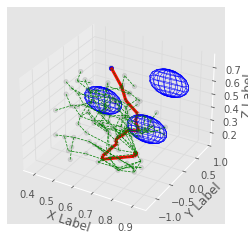

In [7]:
 #Basis example RRT 
n_iter = 1000
radius = 0.2 # radius of the new vertex for rewire step
goal_radius = 0.1 # check the goal radius 
stepSize = 0.1 #the default stepSize when steer

 ## Create Obstacles
S1 = Sphere(Obs1[0],Obs1[1],Obs1[2], Obs1[3])
S2 = Sphere(Obs2[0],Obs2[1],Obs2[2], Obs2[3])
S3 = Sphere(Obs3[0],Obs3[1],Obs3[2], Obs3[3])
Obstacles=[S1, S2, S3]
# print(isInObstacle([1, 1, 1], Obstacles, 1.0))
G1 = RRT_star(startpos, endpos, n_iter, radius, goal_radius, stepSize, Obstacles)
print(G1.success)
if G1.success:
    path = dijkstra(G1)
    print(path)
    plot(G1,Obstacles, path)
else:
    plot(G1, Obstacles)  

In [8]:
#print the list of waypoints in Swift
for i in range (len(path)):
    points= Home
    points.A[:3, 3] = path[i]
    goal_axes = sg.Axes(0.03)
    goal_axes.T = points
    env.add(goal_axes) 

## The main MMC code 

In [9]:
def MMC_move(Tep):
    arrived = False
    while not arrived:
        # Change the Tep frequently
        #target.v = [0.03, 0.03, 0.0, 0.1, 0.1, 0.1]
        # The pose of the UR10e's end-effector
        Te = UR10e.fkine(UR10e.q)

        # Transform from the end-effector to desired pose
        eTep = Te.inv() * Tep

        # Spatial error
        e = np.sum(np.abs(np.r_[eTep.t, eTep.rpy() * np.pi / 180]))

        # Calulate the required end-effector spatial velocity for the robot
        # to approach the goal. Gain is set to 1.0
         # Specify the gain for the p_servo method
        gain = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
        # Calulate the required end-effector spatial velocity for the robot
        # to approach the goal. Gain is set to 1.0
        v, arrived = rtb.p_servo(Te, Tep, gain=gain, threshold=0.05) #threshold=0.01

        # Gain term (lambda) for control minimisation
        Y = 0.01

        # Quadratic component of objective function
        Q = np.eye(n + 6)

        # Joint velocity component of Q
        Q[:n, :n] *= Y

        # Slack component of Q
        Q[n:, n:] = (1 / e) * np.eye(6)

        # The equality contraints
        Aeq = np.c_[UR10e.jacobe(UR10e.q), np.eye(6)]
        beq = v.reshape((6,))

        # The inequality constraints for joint limit avoidance
        Ain = np.zeros((n + 6, n + 6))
        bin = np.zeros(n + 6)

        # The minimum angle (in radians) in which the joint is allowed to approach
        # to its limit
        ps = 0.2

        # The influence angle (in radians) in which the velocity damper
        # becomes active
        pi = 0.8

        # Form the joint limit velocity damper
        Ain[:n, :n], bin[:n] = UR10e.joint_velocity_damper(ps, pi, n)

        # Linear component of objective function: the manipulability Jacobian
        c = np.r_[-UR10e.jacobm(UR10e.q).reshape((n,)), np.zeros(6)]

        # The lower and upper bounds on the joint velocity and slack variable
        UR10e_qdlim = [2.175, 2.175, 2.175,  2.175, 2.61,  2.61]
        lb = -np.r_[UR10e_qdlim, 10 * np.ones(6)]
        ub = np.r_[UR10e_qdlim, 10 * np.ones(6)]

        # Solve for the joint velocities dq
        qd = qp.solve_qp(Q, c, Ain, bin, Aeq, beq, lb=lb, ub=ub, solver='osqp')

        # Apply the joint velocities to the UR10e
        UR10e.qd[:n] = qd[:n]

        # Step the simulator by 50 ms
        env.step(0.01)


In [10]:
Home = UR10e.fkine(UR10e.q)
waypoints = []

#print(path)
for i in range (len(path)):
    points= Home
    points.A[:3, 3] = path[i]
    print(points)
    MMC_move(points)

   0         0         1         0.8       
   0         1         0        -0.6       
  -1         0         0         0.3       
   0         0         0         1         

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using r

/Users/robotlab/miniconda3/envs/rtp/lib/python3.8/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(
/Users/robotlab/miniconda3/envs/rtp/lib/python3.8/site-packages/qpsolvers/solvers/typing.py:48: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(


More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
   0         0         1         0.6377    
   0         1         0        -0.6487    
  -1         0         0         0.1852    
   0         0         0         1         

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using r

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
   0         0         1         0.6416    
   0         1         0        -0.1511    
  -1         0         0         0.2102    
   0         0         0         1         

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using r

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin

More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, using robot.ee_links[0]
More than one end-effector present, usin